---
title: "Quantizing an Object Detection Model in PyTorch"
author: "me"
date: 2023-11-15
draft: false
---

At the time of writing this, quantization in PyTorch was relatively new to me.  After reading about the advantages of quantization aware training, I wanted a deep dive on eager mode quantization and for something non-trivial.  In my research I came across [multiple discussions](https://github.com/pytorch/pytorch/issues/31316) online requesting either [help](https://discuss.pytorch.org/t/slow-inference-time-on-quantized-faster-rcnn-model/115182) or [a tutorial](https://discuss.pytorch.org/t/tutorial-on-quantizing-object-detection-model/102604) for quantizing the backbone of an object detection model (faster R-CNN in this case).  As far as I could tell there was nothing out there and it got me wondering.  Are there no tutorials because it's too difficult or maybe not worth it?  Surely there is some advantage with respect to memory requirements or latency (although maybe not better than GPU).  In any case, this was the perfect excuse for a deep dive.

It's worth mentioning that I ran into all sorts of issues on my early attempts.  This post is polished and makes the whole process look linear but it really wasn't.  There were many attempts, breaks to research bugs, figuring out how to do a thing, reverting to simpler models, etc.  I failed and failed, then finally began to understand things, and only then did it work.

### Network Modifications

The first step in setting up the network for quantization is to create a modified [bottleneck block](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L108).  This isn't obvious until you try to quantize the ResNet without it.  You will get an error `.. out += identity .. Could not run 'aten::add.out' ..` which means that PyTorch isn't able to quantize the skip connection using the `+=` operator in eager mode.  [This discussion on the pytorch forums](https://discuss.pytorch.org/t/quantizing-an-existing-object-detector-with-resnet-backbone/134627) was helpful for describing the error as well as how to fix it.  The modified bottleneck block just uses [FloatFunctional](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.FloatFunctional.html) which has a quantized addition operator.  I'm using ResNet 101 here but for much smaller networks you would want to modify the basic block.  Also, the original bottleneck class reuses the ReLU layer which won't work when fusing.  Finding [this blog post](https://leimao.github.io/blog/PyTorch-Static-Quantization/) about quantizing ResNet was helpful for realizing and avoiding that pitfall.

In [244]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor

from torchvision.models.resnet import conv1x1, conv3x3
from torch.ao.nn.quantized import FloatFunctional


class BottleneckFloatFunctional(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.f_add = nn.quantized.FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.f_add.add(out, identity)
        out = self.relu3(out)

        return out

Now we can simply plug in that class to generate the ResNet.  Even though the float functional operator was added, we can still load pretrained imagenet weights since the weights/submodules didn't change.  Note that the number of classes for the ResNet don't matter here because we will extract intermediate layers and not the final fully connected layer (more on that ahead).

In [245]:
from torchvision.models.resnet import ResNet, ResNet50_Weights, ResNet101_Weights


def resnet101_ff():
    return ResNet(block=BottleneckFloatFunctional, layers=[3, 4, 23, 3])


res101_backbone_ff = resnet101_ff()
res101_backbone_ff.load_state_dict(ResNet101_Weights.DEFAULT.get_state_dict(progress=True))

<All keys matched successfully>

I'm assuming some familiarity with the R-CNN architecture but to refresh, the feature pyramid network uses output from consecutive layers of the ResNet backbone to extract semantically rich information at different resolutions.  Torchvision has a [convenience class for the FPN](https://github.com/pytorch/vision/blob/main/torchvision/ops/feature_pyramid_network.py#L36) that takes as input an OrderedDict containing the output of backbone layers (no final fully connected layer).

To get the layer outputs from the backbone, we can use a utility class [IntermediateLayerGetter](https://github.com/pytorch/vision/blob/main/torchvision/models/_utils.py#L13) (type `nn.ModuleDict`) that returns an `OrderedDict` of layer outputs given the layer names.  There is also a [convenience class](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py#L13) `BackboneWithFPN` which uses the intermediate layer getter but creating the FPN that way doesn't allow the backbone to be quantized.

As an aside, it looks like the control flow (for loop) in `IntermediateLayerGetter` is one reason that the network is [not symbolically traceable](https://pytorch.org/docs/stable/fx.html#dynamic-control-flow) and why graph FX mode quantization can't be used here.

In [246]:
from torchvision.models._utils import IntermediateLayerGetter


returned_layers = [1, 2, 3, 4]  # get all 4 layers
return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)}  # {'layer1': 0, 'layer2': 1, ...}

res101_backbone_layers = IntermediateLayerGetter(res101_backbone_ff, return_layers=return_layers)

Here's an example of what the intermediate output looks like for a toy image.

In [247]:
out = res101_backbone_layers(torch.rand(1, 3, 200, 200))  # e.g. 200 x 200 image with 3 channels

[(k, v.shape) for k, v in out.items()]

[('0', torch.Size([1, 256, 50, 50])),
 ('1', torch.Size([1, 512, 25, 25])),
 ('2', torch.Size([1, 1024, 13, 13])),
 ('3', torch.Size([1, 2048, 7, 7]))]

Wrapping the module dict backbone in sequential layer with quant/dequant stubs causes issues downstream when quantizing, so we need to create an `nn.Module` wrapper class manually.

In [248]:
from typing import Callable, Dict, List, Optional, Union
from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool


class QuantLayers(torch.nn.Module):

    def __init__(self, layers_module_dict: torch.nn.ModuleDict):
        super().__init__()
        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.layers = layers_module_dict

    def forward(self, x):
        x = self.quant(x)
        out = self.layers(x)
        for k, v in out.items():
            out[k] = self.dequant(v)
        return out

Next step is to create a modified backbone with FPN.  This follows the `BackboneWithFPN` class but just uses the wrapped module dict above with quantized inputs and dequantized outputs so they can be fed to the FPN.
 The feature pyramid network also needs to know the exact dimensions of each output from the resnet backbone so we'll get that below.

In [249]:
class QuantBackboneWithFPN(nn.Module):

    def __init__(
        self,
        backbone: nn.Module,
        return_layers: Dict[str, str],
        in_channels_list: List[int],
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        self.body = QuantLayers(
            IntermediateLayerGetter(backbone, return_layers=return_layers)
        )
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer,
        )
        self.out_channels = out_channels

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        x = self.body(x)
        x = self.fpn(x)
        return x

In [250]:
#  there are several ways to get these dimensions

# from backbone_utils.py: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py#L145
# in_channels_stage2 = res101_backbone_layers.inplanes // 8
# in_channels_list = [in_channels_stage2 * 2 ** (i - 1) for i in returned_layers]

in_channels_list = []
for k1, m1 in res101_backbone_layers.named_children():
  if 'layer' in k1:
    in_channels_list.append((m1[-1].bn3.num_features))

in_channels_list

[256, 512, 1024, 2048]

Another important note is that regular `BatchNorm2d` is used here instead of `FrozenBatchNorm2d` because the latter isn't quantizeable.  Frozen batch norm is the recommended layer because batches are generally [too small for good estimates of mean and variance](https://github.com/facebookresearch/maskrcnn-benchmark/issues/267) statistics.  So using regular batch norm could be unstable and less performant if those layers aren't frozen.

In [251]:
res101_bb_fpn = QuantBackboneWithFPN(
    backbone=res101_backbone_layers,
    return_layers=return_layers,
    in_channels_list=in_channels_list,
    out_channels=256,  # defined
    extra_blocks=None,  # defaults to LastLevelMaxPool, see above
    norm_layer=None,  # defaults to torch.nn.BatchNorm2d, see FeaturePyramidNetwork
)
# res101_bb_fpn

At this point there should be quant/dequant stubs in the network similar to below.

```
QuantBackboneWithFPN(
  (body): QuantLayers(
    (quant): QuantStub()
    (dequant): DeQuantStub()
    (layers): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      ...
```

Once the backbone with FPN is created, it can be plugged into the `FasterRCNN` [torchvision class](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py#L43).  The number of classes is set to 2 for object or background (specific to the dataset used here).

In [252]:
from torchvision.models.detection.faster_rcnn import FasterRCNN


quant_rcnn_res101 = FasterRCNN(res101_bb_fpn, num_classes=2)
# quant_rcnn_res101

### Layer Fusion and Quantization Config

Before training and subsequently converting the model, we can fuse specific sequences of modules in the backbone.  Fusing compresses the model [making it smaller and run faster](https://pytorch.org/tutorials/recipes/fuse.html).  Below sequences of `Conv2d-BatchNorm2d-ReLU` and `Conv2d-BatchNorm2d` are fused.  After fusing you should see new fused modules in the network (shown below) like `ConvReLU2d` as well as `Identity`.

```
(backbone): QuantBackboneWithFPN(
    (body): QuantLayers(
      (quant): QuantStub()
      (dequant): DeQuantStub()
      (layers): IntermediateLayerGetter(
        (conv1): ConvReLU2d(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
          (1): ReLU(inplace=True)
        )
        (bn1): Identity()
        (relu): Identity()
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BottleneckFloatFunctional(
            (conv1): ConvReLU2d(
              (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              (1): ReLU(inplace=True)
            )
            (bn1): Identity()
            (relu1): Identity()
            ...
```

In [253]:
from torch.ao.quantization import fuse_modules


quant_rcnn_res101.eval()
# fuse stem
fuse_modules(quant_rcnn_res101.backbone.body.layers, [['conv1', 'bn1', 'relu']], inplace=True)
# fuse blocks
for k1, m1 in quant_rcnn_res101.backbone.body.layers.named_children():
    if "layer" in k1:  # in sequential layer with blocks
        for k2, m2 in m1.named_children():
            fuse_modules(m2, [["conv1", "bn1", "relu1"], ["conv2", "bn2", "relu2"], ["conv3", "bn3"]], inplace=True)
            for k3, m3 in m2.named_children():
                if "downsample" in k3:  # fuse downsample
                    fuse_modules(m3, [["0", "1"]], inplace=True)

Before training the qconfig needs to be set but on the resnet backbone only.  And again, because the batches are so small, batch norm gets frozen using the handy API found in [this PyTorch tutorial](https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html#quantization-aware-training).  Last, I'll freeze the stem and the first layer in the backbone since the pretrained imagenet weights were loaded.  After preparation you should be able to see the observers in the network.

```
(backbone): QuantBackboneWithFPN(
    (body): QuantLayers(
      (quant): QuantStub(
        (activation_post_process): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
          (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
        )
      )
      (dequant): DeQuantStub()
      (layers): IntermediateLayerGetter(
        (conv1): ConvReLU2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)
          (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
            fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
            (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
          )
          (activation_post_process): FusedMovingAvgObsFakeQuantize(
            fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
            (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
          )
        )
        (bn1): Identity()
        (relu): Identity()
        ...
```

In [254]:
import re


# for backend in torch.backends.quantized.supported_engines:
#     print(backend)

quant_rcnn_res101.train()
quant_rcnn_res101.backbone.body.qconfig = torch.ao.quantization.get_default_qat_qconfig('fbgemm')
quant_rcnn_res101_prepared = torch.ao.quantization.prepare_qat(quant_rcnn_res101, inplace=False)

quant_rcnn_res101_prepared = quant_rcnn_res101_prepared.apply(torch.nn.intrinsic.qat.freeze_bn_stats)

quant_rcnn_res101_prepared.backbone.body.layers.conv1.weight.requires_grad = False
for name, parameter in quant_rcnn_res101_prepared.backbone.body.named_parameters():
    if re.search(r".layer1", name):
        parameter.requires_grad = False

### Dataset, Training, and Conversion

I'll be using the [PennFudan dataset](https://www.cis.upenn.edu/~jshi/ped_html/) from the [Torchvision object detection finetuning tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) for QAT.  Most of the code below is borrowed from that tutorial with slight modifications since I don't perform segmentation.

In [255]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [105]:
%%capture

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip -d ./

In [256]:
import utils
from engine import train_one_epoch, evaluate


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [257]:
# move model to the right device
quant_rcnn_res101_prepared.to(device)

# construct an optimizer
params = [p for p in quant_rcnn_res101_prepared.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(quant_rcnn_res101_prepared, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(quant_rcnn_res101_prepared, data_loader_test, device=device)


Epoch: [0]  [ 0/60]  eta: 0:01:05  lr: 0.000090  loss: 1.6602 (1.6602)  loss_classifier: 0.9224 (0.9224)  loss_box_reg: 0.0023 (0.0023)  loss_objectness: 0.7214 (0.7214)  loss_rpn_box_reg: 0.0140 (0.0140)  time: 1.0922  data: 0.2625  max mem: 9188
Epoch: [0]  [10/60]  eta: 0:00:40  lr: 0.000936  loss: 0.7143 (0.9616)  loss_classifier: 0.0847 (0.3113)  loss_box_reg: 0.0019 (0.0041)  loss_objectness: 0.6638 (0.6250)  loss_rpn_box_reg: 0.0206 (0.0212)  time: 0.8087  data: 0.0288  max mem: 9188
Epoch: [0]  [20/60]  eta: 0:00:31  lr: 0.001783  loss: 0.5990 (0.7357)  loss_classifier: 0.1087 (0.2302)  loss_box_reg: 0.0221 (0.0527)  loss_objectness: 0.3577 (0.4293)  loss_rpn_box_reg: 0.0206 (0.0235)  time: 0.7719  data: 0.0054  max mem: 9188
Epoch: [0]  [30/60]  eta: 0:00:23  lr: 0.002629  loss: 0.3487 (0.5963)  loss_classifier: 0.1135 (0.1929)  loss_box_reg: 0.0837 (0.0640)  loss_objectness: 0.0951 (0.3145)  loss_rpn_box_reg: 0.0212 (0.0250)  time: 0.7637  data: 0.0054  max mem: 9188
Epoch: [

Now to convert model and save the model.  Make sure to put the model on CPU before conversion or you will get an error.  After conversion you should see quantized modules like `QuantizedConvReLU2d`.

```
(backbone): QuantBackboneWithFPN(
    (body): QuantLayers(
      (quant): Quantize(scale=tensor([0.0374]), zero_point=tensor([56]), dtype=torch.quint8)
      (dequant): DeQuantize()
      (layers): IntermediateLayerGetter(
        (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.3137107789516449, zero_point=0, padding=(3, 3))
        (bn1): Identity()
        (relu): Identity()
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BottleneckFloatFunctional(
            (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.15175238251686096, zero_point=0)
            (bn1): Identity()
            (relu1): Identity()
            ...
```

In [258]:
quant_rcnn_res101_prepared.eval()
quant_rcnn_res101_prepared.to(torch.device('cpu'))

quant_rcnn_res101_converted = torch.ao.quantization.convert(quant_rcnn_res101_prepared, inplace=False)

quant_model_101_path = "/content/quant_model_101.pth"
torch.save(quant_rcnn_res101_converted.state_dict(), quant_model_101_path)

For comparison I'll generate the same network without any modifications made for quantization (including fusion).  Then we can compare model sizes and latency.  Note that this is just comparing latency on the CPU, if the float model was on GPU it could be significantly faster depending upon the hardware.

In [259]:
%%capture
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.resnet import Bottleneck


res101_backbone = ResNet(block=Bottleneck, layers=[3, 4, 23, 3])
res101_backbone.load_state_dict(ResNet101_Weights.DEFAULT.get_state_dict(progress=False))
rcnn_res101 = FasterRCNN(
    BackboneWithFPN(
        backbone=res101_backbone,
        return_layers=return_layers,
        in_channels_list=in_channels_list,
        out_channels=256,
        extra_blocks=None,
        norm_layer=None,
        ),
    num_classes=2
)

rcnn_res101.eval()
rcnn_res101.to(torch.device('cpu'))
model_101_path = "/content/model_101.pth"
torch.save(rcnn_res101.state_dict(), model_101_path)

In [260]:
print(f'size of quantized model: {round(os.path.getsize("/content/quant_model_101.pth") / 1e6)} MB')
print(f'size of float model: {round(os.path.getsize("/content/model_101.pth") / 1e6)} MB')

size of quantized model: 115 MB
size of float model: 242 MB


In [261]:
from time import perf_counter

# just grab one test image/batch
images, targets = next(iter(data_loader_test))
images = list(img.to(torch.device('cpu')) for img in images)
n = 10

start = perf_counter()
for _ in range(n):
    __ = quant_rcnn_res101_converted(images)
print(f"quant model avg time: {(perf_counter() - start) / n:.2f}")

start = perf_counter()
for _ in range(n):
    __ = rcnn_res101(images)
print(f"float model (cpu) avg time: {(perf_counter() - start) / n:.2f}")

quant model avg time: 1.84
float model (cpu) avg time: 2.39


I believe a fully quantized model would be even smaller and faster by comparison.  In this case, while we did quantize the backbone for the RCNN, it only accounted for roughly 70% of the model parameters.  So a significant number of float operations still occur after the quantized backbone.

In [262]:
num_model_params = sum(p.numel() for p in rcnn_res101.parameters() if p.requires_grad)
num_backbone_params = sum(p.numel() for p in rcnn_res101.backbone.body.parameters() if p.requires_grad)

print(f"total number of parameters in model: {num_model_params}")
print(f"total number of parameters in backbone: {num_backbone_params}")
print(f"ratio of quantized parameters: {num_backbone_params / num_model_params:.2f}")

total number of parameters in model: 60344409
total number of parameters in backbone: 42500160
ratio of quantized parameters: 0.70


We can also profile each model to see where each spends the most time during a forward pass.

In [263]:
from torch.profiler import profile, record_function, ProfilerActivity


with profile(activities=[ProfilerActivity.CPU], record_shapes=False) as prof:
    with record_function("model_inference"):
        quant_rcnn_res101_converted(images)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

with profile(activities=[ProfilerActivity.CPU], record_shapes=False) as prof:
    with record_function("model_inference"):
        rcnn_res101(images)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         1.55%      31.980ms       100.00%        2.068s        2.068s             1  
           quantized::conv2d_relu        34.88%     721.174ms        35.12%     726.108ms      10.837ms            67  
                     aten::conv2d         0.01%     277.000us        22.65%     468.216ms      20.357ms            23  
                aten::convolution         0.02%     463.000us        22.64%     468.117ms      20.353ms            23  
               aten::_convolution         0.02%     478.000us        22.62%     467.654ms      20.333ms            23  
         aten::mkldnn_convolution       

The following loads the saved quantized model.  It's important that the same process of [fusing, preparing, and converting](https://discuss.pytorch.org/t/how-to-load-quantized-model-for-inference/140283) be done before loading weights since quantization significantly alters the network.  For sake of completeness, we can look at a prediction from the partially quantized RCNN.

In [264]:
%%capture

quant_model_loaded = FasterRCNN(
    QuantBackboneWithFPN(
        backbone=resnet101_ff(),
        return_layers=return_layers,
        in_channels_list=in_channels_list,
        out_channels=256,
        extra_blocks=None,
        norm_layer=None
        ),
    num_classes=2
    )

quant_model_loaded.eval()
fuse_modules(quant_model_loaded.backbone.body.layers, [['conv1', 'bn1', 'relu']], inplace=True)
for k1, m1 in quant_model_loaded.backbone.body.layers.named_children():
    if "layer" in k1:  # in sequential layer with blocks
        for k2, m2 in m1.named_children():
            fuse_modules(m2, [["conv1", "bn1", "relu1"], ["conv2", "bn2", "relu2"], ["conv3", "bn3"]], inplace=True)
            for k3, m3 in m2.named_children():
                if "downsample" in k3:  # fuse downsample
                    fuse_modules(m3, [["0", "1"]], inplace=True)

quant_model_loaded.train()
quant_model_loaded.backbone.body.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare_qat(quant_model_loaded, inplace=True)
torch.quantization.convert(quant_model_loaded, inplace=True)

quant_model_loaded.eval()
quant_model_loaded.load_state_dict(torch.load(quant_model_101_path, map_location=torch.device('cpu')))

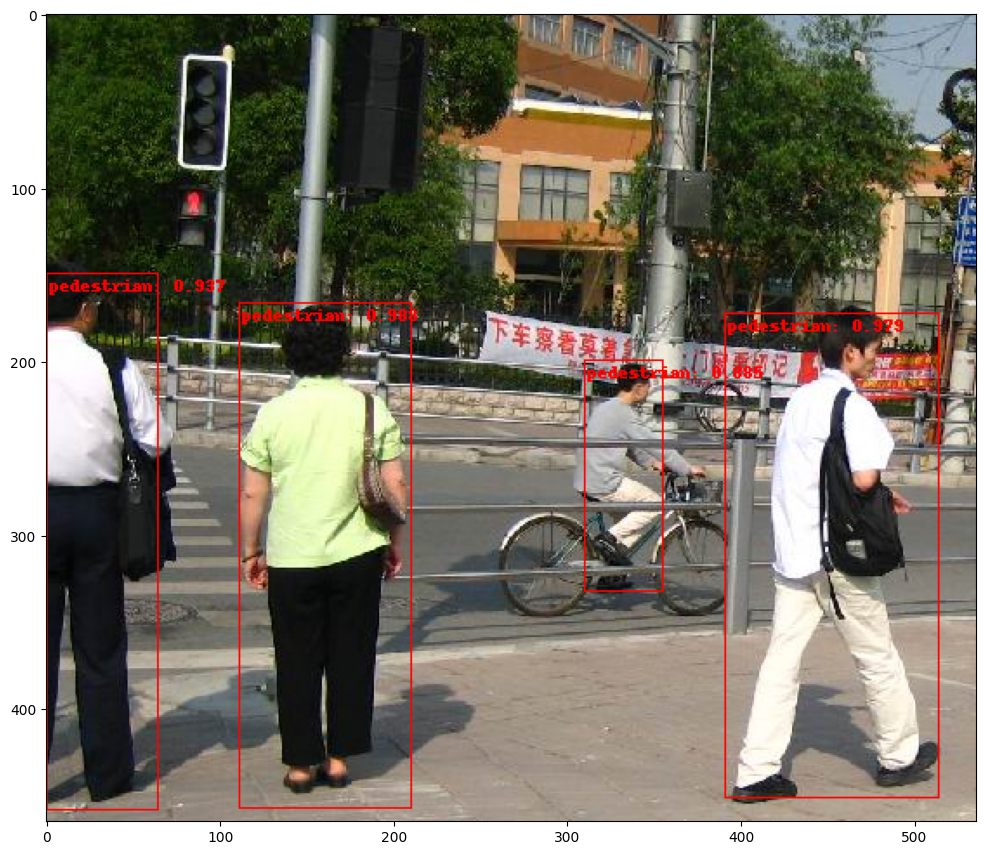

In [267]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("PennFudanPed/PNGImages/FudanPed00022.png")  # 7, 22
eval_transform = get_transform(train=False)

with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(torch.device('cpu'))
    predictions = quant_model_loaded([x, ])
    pred = predictions[0]

threshold = 0.80
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"]) if score > threshold]
pred_boxes = pred["boxes"].long()[pred["scores"] > threshold]

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))